=== ANALISIS SENTIMEN KOMENTAR YOUTUBE ===

Berhasil load 17206 komentar dari demodpr25agustus2025.xlsx
Total komentar: 17206

Preprocessing komentar...
Komentar valid setelah preprocessing: 17163

Menghitung TF-IDF dengan optimasi memory...
Vocabulary dikurangi dari 24761 ke 5000 kata
Processing document 0/17163
Processing document 1000/17163
Processing document 2000/17163
Processing document 3000/17163
Processing document 4000/17163
Processing document 5000/17163
Processing document 6000/17163
Processing document 7000/17163
Processing document 8000/17163
Processing document 9000/17163
Processing document 10000/17163
Processing document 11000/17163
Processing document 12000/17163
Processing document 13000/17163
Processing document 14000/17163
Processing document 15000/17163
Processing document 16000/17163
Processing document 17000/17163
TF-IDF Matrix shape: (17163, 5000)
Vocabulary size: 5000

Melakukan K-Means clustering (k=3)...
Iteration 1/100
Iteration 2/100
Iteration 3/100
Iterat

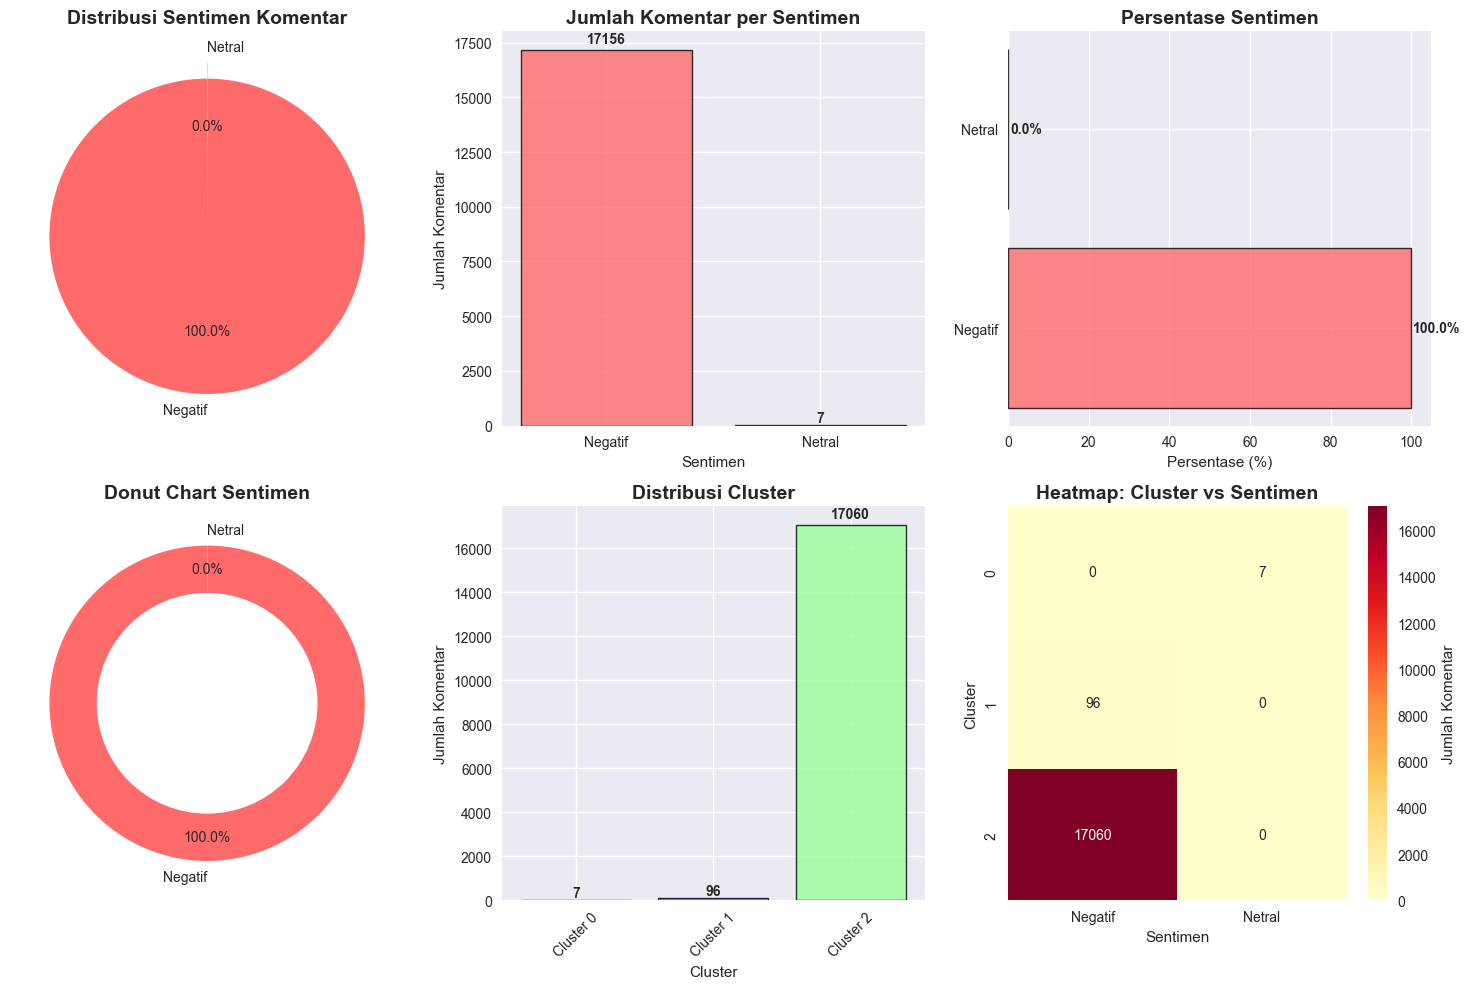

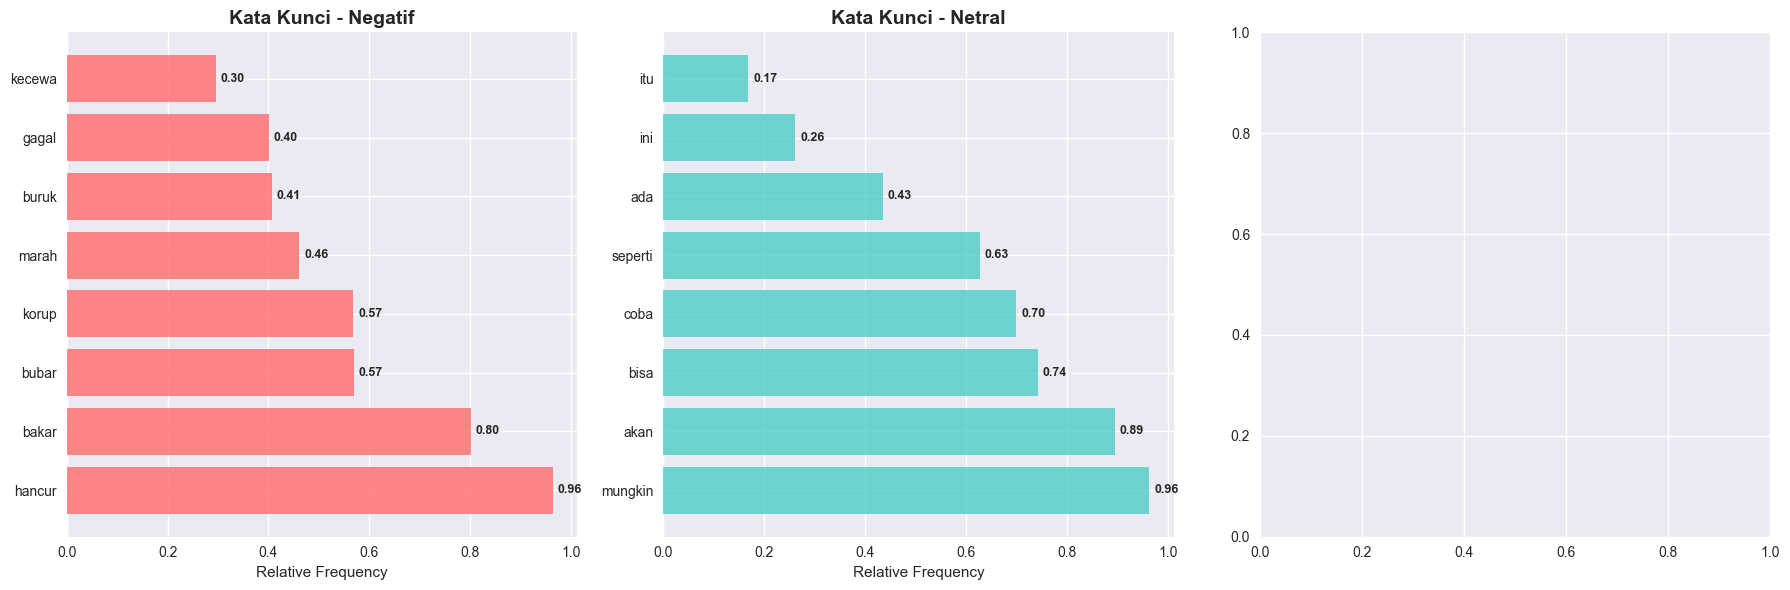


           RINGKASAN STATISTIK
📊 Total Komentar Dianalisis: 17,163
🔢 Jumlah Cluster Terbentuk: 3

📈 DISTRIBUSI SENTIMEN:
   Negatif : 17,156 (100.0%) █████████████████████████████████████████████████
   Netral  :     7 (  0.0%) 

🎯 DOMINASI SENTIMEN:
   Sentimen 'Negatif' mendominasi dengan 100.0%

🔍 ANALISIS CLUSTER:
   Cluster 0: Netral (7 komentar, 0.0%)
   Cluster 1: Negatif (96 komentar, 0.6%)
   Cluster 2: Negatif (17,060 komentar, 99.4%)

=== SAMPLE HASIL ===
                                             Comment Sentiment  Cluster
0                                    Bubarin aj  DPR   Negatif        2
1                Yang Tetjadi Penderitaan Ada Korban   Negatif        2
2    kayanya bakalan kembali \nkemasa 98\nbaru beres   Negatif        2
3  Hancur kan saja rakyat mendukung masa..\nApara...   Negatif        2
4  bakar aja gedung dpr nya. dengan orang虏nya sek...   Negatif        2
5             Presiden bhgian dia liat ini pasti itu   Negatif        2
6  Indonesia  corrupt   

In [ ]:
from flask import Flask, request, jsonify, render_template_string
from flask_cors import CORS
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix
from collections import Counter
import re
import io
import json
import time
from werkzeug.utils import secure_filename
import os

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes

# Configuration
UPLOAD_FOLDER = 'uploads'
ALLOWED_EXTENSIONS = {'xlsx', 'xls'}
MAX_CONTENT_LENGTH = 16 * 1024 * 1024  # 16MB max file size

app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = MAX_CONTENT_LENGTH

# Create upload directory if it doesn't exist
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

# Backend sentiment analysis functions (dari kode Python Anda)
def load_comments_from_excel(file_path):
    """Load komentar dari file Excel"""
    try:
        df = pd.read_excel(file_path)
        
        comment_columns = ['comment', 'Comment', 'AuthorComment', 'text', 'Text', 'Komentar']
        comment_col = None
        
        for col in comment_columns:
            if col in df.columns:
                comment_col = col
                break
        
        if comment_col is None:
            return []
        
        comments = df[comment_col].dropna().astype(str).tolist()
        return comments
        
    except Exception as e:
        print(f"Error loading Excel: {e}")
        return []

def preprocess(text):
    """Preprocessing teks"""
    if pd.isna(text):
        return []
    
    text = str(text).lower()
    
    # Hapus URL, mention, hashtag
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = [word for word in text.split() if len(word) > 2]
    return words

def calculate_tfidf(processed_comments, max_features=3000, min_df=2):
    """Hitung TF-IDF matrix dengan optimasi memory"""
    word_freq = Counter()
    for doc in processed_comments:
        word_freq.update(set(doc))
    
    valid_words = [word for word, freq in word_freq.items() if freq >= min_df]
    
    if len(valid_words) > max_features:
        valid_words = [word for word, freq in word_freq.most_common(max_features)]
    
    word_to_idx = {word: i for i, word in enumerate(valid_words)}
    
    N = len(processed_comments)
    tfidf = lil_matrix((N, len(valid_words)), dtype=np.float32)
    
    for i, doc in enumerate(processed_comments):
        if not doc:
            continue
                
        word_count = Counter(doc)
        doc_length = len(doc)
        
        for word, count in word_count.items():
            if word not in word_to_idx:
                continue
                
            tf = count / doc_length
            df = word_freq[word]
            idf = np.log(N / (1 + df))
            tfidf[i, word_to_idx[word]] = tf * idf
    
    return tfidf.tocsr(), word_to_idx

def kmeans(X, k=3, max_iter=50, random_state=42):
    """K-Means clustering untuk sparse matrix"""
    np.random.seed(random_state)
    
    if hasattr(X, 'toarray'):
        if X.shape[0] > 5000:
            sample_indices = np.random.choice(X.shape[0], min(1000, X.shape[0]), replace=False)
            X_sample = X[sample_indices].toarray()
            initial_centroids = X_sample[np.random.choice(X_sample.shape[0], k, replace=False)]
        else:
            X_dense = X.toarray()
            initial_centroids = X_dense[np.random.choice(X_dense.shape[0], k, replace=False)]
    else:
        initial_centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    
    centroids = initial_centroids.astype(np.float32)
    
    for iteration in range(max_iter):
        if hasattr(X, 'toarray'):
            distances = []
            batch_size = 1000
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:i+batch_size].toarray().astype(np.float32)
                batch_distances = np.linalg.norm(batch[:, np.newaxis] - centroids, axis=2)
                distances.append(batch_distances)
            distances = np.vstack(distances)
        else:
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        
        labels = np.argmin(distances, axis=1)
        
        new_centroids = []
        for i in range(k):
            mask = labels == i
            if np.any(mask):
                if hasattr(X, 'toarray'):
                    cluster_points = X[mask].toarray().astype(np.float32)
                else:
                    cluster_points = X[mask].astype(np.float32)
                new_centroids.append(cluster_points.mean(axis=0))
            else:
                new_centroids.append(centroids[i])
        
        new_centroids = np.array(new_centroids)
        
        if np.allclose(centroids, new_centroids, atol=1e-4):
            break
            
        centroids = new_centroids
    
    return labels, centroids

def label_sentiments(centroids, word_to_idx):
    """Label cluster berdasarkan lexicon sentiment"""
    neg_words = {
        'hancur', 'bakar', 'bubar', 'korup', 'marah', 'sengsara', 'rusak', 
        'anarkis', 'jahat', 'bodoh', 'tolol', 'benci', 'kecewa', 'buruk', 
        'jelek', 'gagal', 'sedih', 'stress', 'mampus'
    }
    
    pos_words = {
        'semangat', 'dukung', 'mantap', 'hebat', 'merdeka', 'bersatu', 
        'lindungi', 'bagus', 'baik', 'senang', 'bangga', 'optimis',
        'sukses', 'berhasil', 'luar', 'biasa', 'keren', 'amazing'
    }
    
    cluster_labels = []
    
    for i, centroid in enumerate(centroids):
        neg_score = sum(centroid[word_to_idx[w]] for w in neg_words if w in word_to_idx)
        pos_score = sum(centroid[word_to_idx[w]] for w in pos_words if w in word_to_idx)
        
        if neg_score > pos_score and neg_score > 0:
            cluster_labels.append('Negatif')
        elif pos_score > neg_score and pos_score > 0:
            cluster_labels.append('Positif')
        else:
            cluster_labels.append('Netral')
    
    return cluster_labels

def analyze_sentiment_backend(comments, k_clusters=3):
    """Main sentiment analysis function"""
    # Preprocessing
    processed_comments = [preprocess(c) for c in comments]
    
    # Filter empty comments
    valid_indices = [i for i, doc in enumerate(processed_comments) if len(doc) > 0]
    comments = [comments[i] for i in valid_indices]
    processed_comments = [processed_comments[i] for i in valid_indices]
    
    if len(comments) == 0:
        return None, "Tidak ada komentar valid setelah preprocessing"
    
    # TF-IDF Calculation
    tfidf_matrix, word_to_idx = calculate_tfidf(processed_comments)
    
    # K-Means Clustering
    labels, centroids = kmeans(tfidf_matrix, k=k_clusters)
    
    # Sentiment Labeling
    cluster_sentiments = label_sentiments(centroids, word_to_idx)
    
    # Map labels to sentiments
    sentiments = [cluster_sentiments[label] for label in labels]
    
    # Create result DataFrame
    df_result = pd.DataFrame({
        'Comment': comments,
        'Sentiment': sentiments,
        'Cluster': labels
    })
    
    return df_result, None

# Routes
@app.route('/')
def index():
    # Serve the HTML file dari dokumen Anda
    with open('sentiment_analysis.html', 'r', encoding='utf-8') as f:
        html_content = f.read()
    return html_content

@app.route('/upload', methods=['POST'])
def upload_file():
    try:
        if 'file' not in request.files:
            return jsonify({'error': 'No file uploaded'}), 400
        
        file = request.files['file']
        if file.filename == '':
            return jsonify({'error': 'No file selected'}), 400
        
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            
            # Load comments from Excel
            comments = load_comments_from_excel(filepath)
            
            if not comments:
                return jsonify({'error': 'Tidak dapat membaca komentar dari file'}), 400
            
            # Perform sentiment analysis
            df_result, error = analyze_sentiment_backend(comments)
            
            if error:
                return jsonify({'error': error}), 400
            
            # Prepare response data
            sentiment_counts = df_result['Sentiment'].value_counts()
            cluster_counts = df_result['Cluster'].value_counts()
            
            # Sample data untuk tabel (max 50 items)
            sample_data = df_result.head(50).to_dict('records')
            
            response_data = {
                'totalComments': len(df_result),
                'sentiments': sentiment_counts.to_dict(),
                'clusters': {f'Cluster {k}': v for k, v in cluster_counts.to_dict().items()},
                'sampleData': [
                    {
                        'comment': row['Comment'][:100] + '...' if len(row['Comment']) > 100 else row['Comment'],
                        'sentiment': row['Sentiment'],
                        'cluster': row['Cluster']
                    }
                    for row in sample_data
                ]
            }
            
            # Cleanup uploaded file
            os.remove(filepath)
            
            return jsonify(response_data)
        
        else:
            return jsonify({'error': 'File type not allowed'}), 400
            
    except Exception as e:
        return jsonify({'error': f'Server error: {str(e)}'}), 500

@app.route('/health')
def health_check():
    return jsonify({'status': 'healthy'})

if __name__ == '__main__':
    # Install required packages
    print("Make sure you have installed the required packages:")
    print("pip install flask flask-cors pandas numpy scipy openpyxl")
    
    app.run(debug=True, host='0.0.0.0', port=5000)